# **Grad-CAM & ResNet-50: Explainability Analysis**

## **Imports**

In [ ]:
import os
import random
import json
import requests
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.linear_model import LogisticRegression

## **Grad-CAM Implementation for CNN Interpretability**
This section implements **Grad-CAM (Gradient-weighted Class Activation Mapping)** to generate visual explanations for CNN-based predictions.



### **1. Model Setup & Image Preprocessing**
- Loads a **pretrained ResNet-50** model.
- Sets the model to **evaluation mode (`eval()`)**.
- Selects the **last convolutional layer** (`layer4[-1]`) as the Grad-CAM target.
- **Preprocessing Pipeline**:
  - Resizes input images to **224×224 pixels**.
  - Converts images to **PyTorch tensors**.
  - Normalizes using **ImageNet mean & std**.



### **2. Grad-CAM Methodology**
Grad-CAM highlights **salient regions** in an image by computing **class-specific activation maps**.

#### **Mathematical Definition**
For a given class **$y$**, Grad-CAM generates a heatmap using the **feature maps** $A_k$ from the last convolutional layer:

$$ L^{\text{Grad-CAM}}_y = \text{ReLU} \left( \sum_k \alpha_k^y A_k \right) $$

where:
- **$A_k$** = Activation map of the **$k^{th}$** feature channel.
- **$\alpha_k^y$** = Importance weight computed as:

$$ \alpha_k^y = \frac{1}{Z} \sum_{i,j} \frac{\partial f_y}{\partial A_k^{(i,j)}} $$

- **$\frac{\partial f_y}{\partial A_k}$** = Gradient of class score w.r.t feature maps.
- **$Z$** = Number of spatial locations in **$A_k$**.
- **ReLU ensures positive contributions** to class activation.


### **3. Grad-CAM Implementation**
The **`GradCAM` class**:
- Registers **hooks** to capture:
  - **Feature maps** (forward pass).
  - **Gradients** (backward pass).
- Computes **Grad-CAM heatmaps** for:
  - **Top-3 predicted classes**.
  - **Least probable class** for comparison.

#### **`generate_cam()`**
- Runs a **forward pass** to get predicted probabilities.
- Computes **class-specific gradients** via **backpropagation**.
- Uses **adaptive average pooling** to generate **importance weights**.
- Combines **feature maps & weights** to compute **Grad-CAM heatmaps**.



### **4. Visualizing Grad-CAM Explanations**
- **`show_grad_cam()`** displays:
  - **Original Image**.
  - **Top-3 class heatmaps** (overlayed on image).
  - **Least probable class heatmap** (in **red** for contrast).

**Example Output:**
- Grad-CAM highlights **relevant object parts** for predicted classes.
- Least probable class heatmap shows **irrelevant feature activations**.



### **5. Running the Grad-CAM Pipeline**
- **Image:** `"TP2_images/2637374064_fab14ec0b8.jpg"`
- **Results:**
  - **Grad-CAM heatmaps** for **top-3 classes**.
  - **Contrastive heatmap** for the **least probable class**.


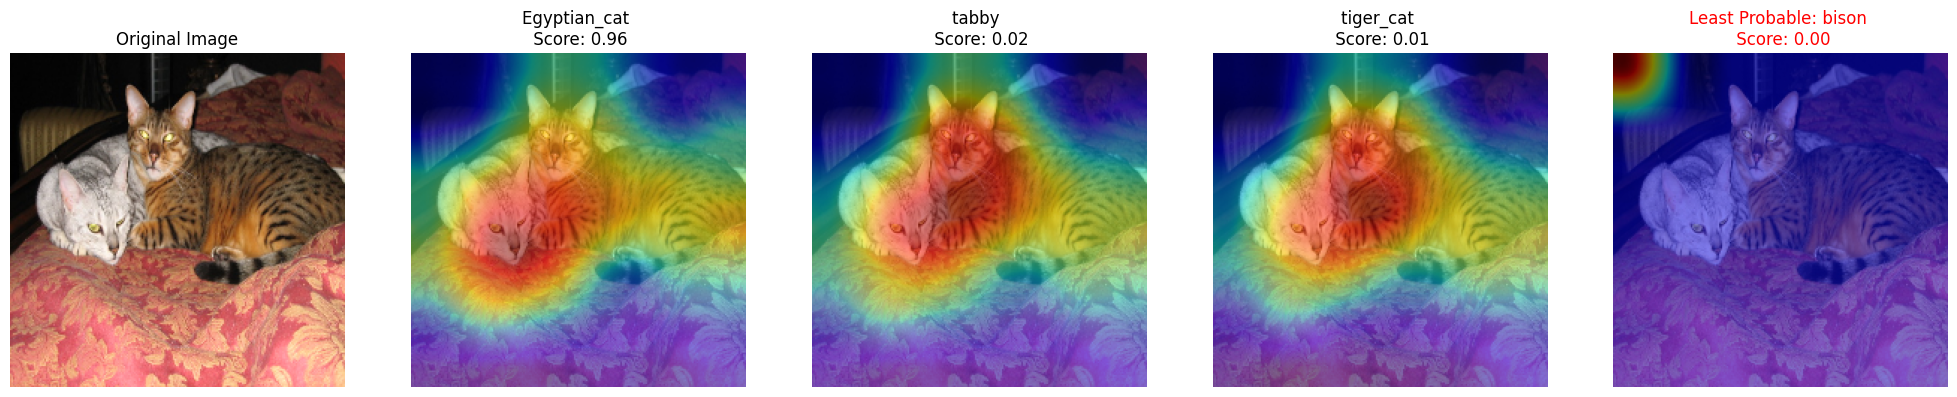

In [ ]:

url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
imagenet_classes = requests.get(url).json()
idx_to_class = {int(k): v[1] for k, v in imagenet_classes.items()}


resnet50 = models.resnet50(pretrained=True)
resnet50.eval()  # Set to evaluation mode

# Pick the **last convolutional layer** of ResNet-50
target_layer = resnet50.layer4[-1]  # The last conv block


class GradCAM:
    """ Implements Grad-CAM to generate visual explanations for CNN predictions. """

    def __init__(self, model, conv_layer):
        self.model = model
        self.conv_layer = conv_layer
        self.feature_map = None
        self.gradient = None

        # Register hooks to capture feature maps & gradients
        self.conv_layer.register_forward_hook(self.forward_hook)

    def forward_hook(self, module, input, output):
        """ Capture feature maps. """
        self.feature_map = output.clone().detach()
        output.register_hook(lambda grad: setattr(self, 'gradient', grad.clone().detach()))

    def forward_pass(self, image):
        """ Runs a forward pass and gets top-3 predictions. """
        output = self.model(image).squeeze()
        probs = F.softmax(output, dim=0)
        values, indices = torch.topk(probs, k=3)

        # Find the least probable class
        least_prob_class = probs.argmin().unsqueeze(0)
        all_classes = torch.cat((indices, least_prob_class), dim=0)

        return output, values, indices, least_prob_class, all_classes, probs, self.feature_map

    def generate_cam(self, image):
        """ Generates Grad-CAM heatmaps for the top-3 classes & least probable class. """
        output, values, indices, least_prob_class, all_classes, probs, feature_map = self.forward_pass(image)
        heatmaps = []

        for label in all_classes:
            self.model.zero_grad()
            one_hot = torch.zeros_like(output)
            one_hot[label] = 1
            output.backward(gradient=one_hot, retain_graph=True)

            gradients = self.gradient.clone().detach()
            weights = F.adaptive_avg_pool2d(gradients, (1, 1))

            # Compute weighted activation map
            cam = torch.sum(weights.view(-1, 1, 1) * feature_map, dim=1, keepdim=True)
            cam = F.relu(cam.clone().detach())  # Apply ReLU
            cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
            cam = cam.squeeze().cpu().numpy()
            heatmaps.append(cam)

        return heatmaps, indices, values, least_prob_class, probs[least_prob_class].item()

    def show_grad_cam(self, image_tensor, orig_image):
        """ Displays Grad-CAM heatmaps for the top-3 classes & least probable class. """
        heatmaps, indices, values, least_prob_class, least_prob_value = self.generate_cam(image_tensor)

        fig, ax = plt.subplots(1, 5, figsize=(25, 5))
        ax[0].imshow(orig_image)
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        # Plot heatmaps for the top-3 predicted classes
        for i in range(3):
            ax[i + 1].imshow(orig_image)
            heatmap = np.mean(heatmaps[i], axis=0) if len(heatmaps[i].shape) > 2 else heatmaps[i]
            class_name = idx_to_class[indices[i].item()]
            ax[i + 1].imshow(heatmap, cmap='jet', alpha=0.5)
            ax[i + 1].set_title(f"{class_name} \n Score: {values[i]:.2f}")
            ax[i + 1].axis("off")

        # Plot the least probable class
        ax[4].imshow(orig_image)
        heatmap = np.mean(heatmaps[3], axis=0) if len(heatmaps[3].shape) > 2 else heatmaps[3]
        class_name = idx_to_class[least_prob_class.item()]
        ax[4].imshow(heatmap, cmap='jet', alpha=0.5)
        ax[4].set_title(f"Least Probable: {class_name} \n Score: {least_prob_value:.2f}", color="red")
        ax[4].axis("off")

        plt.show()


def preprocess_image(image_path):
    """ Loads and preprocesses an image for ResNet-50. """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

def show_grad_cam(image_path):
    """ Wrapper function to preprocess image, compute Grad-CAM, and display results. """
    image_tensor = preprocess_image(image_path)

    # Load original image for visualization
    orig_image = cv2.imread(image_path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    orig_image = cv2.resize(orig_image, (224, 224))

    # Run Grad-CAM and display results
    grad_cam.show_grad_cam(image_tensor, orig_image)


grad_cam = GradCAM(resnet50, target_layer)

image_path = "TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"  
show_grad_cam(image_path)


## **Grad-CAM Evaluation: Robustness, Faithfulness & Localization**
This section evaluates **Grad-CAM** explanations using multiple interpretability metrics. The evaluation tests the reliability of the heatmaps generated for CNN-based predictions.



### **1. Robustness to Noise**
- **Goal**: Check if Grad-CAM heatmaps remain stable under **small perturbations**.
- **Method**:
  - Gaussian noise $ \mathcal{N}(0, \sigma) $  with $  \sigma = 0.1 $  is added to the image.
  - Spearman correlation is computed between original and perturbed heatmaps:

  $$ \rho = \frac{\sum (R_x - \bar{R_x})(R_y - \bar{R_y})}{\sqrt{\sum (R_x - \bar{R_x})^2 \sum (R_y - \bar{R_y})^2}} $$

  - **Higher correlation** means the heatmap is robust.


### **2. Faithfulness: Deletion & Insertion Tests**
- **Goal**: Check if removing or adding important regions affects model confidence.
- **Method**:
  - **Deletion Test**:
    - Remove top **10% most important pixels** in the heatmap.
    - Measure confidence **drop** in the predicted class.
    - **Larger drop = More faithful heatmap**.

  $$ \text{Faithfulness}_{\text{Deletion}} = \int_0^{10} f(y_{del}(p)) dp $$

  - **Insertion Test**:
    - Start with a **zeroed image** and gradually add **important pixels**.
    - Measure confidence **increase** in the predicted class.
    - **Higher increase = More meaningful attributions**.

  $$ \text{Faithfulness}_{\text{Insertion}} = \int_0^{10} f(y_{ins}(p)) dp $$



### **3. Complexity: Explanation Sparsity**
- **Goal**: Check if the explanation is **focused** rather than spread across the image.
- **Method**:
  - Computes the fraction of pixels with **high attributions**:

  $$ C = \frac{1}{N} \sum_{i,j} \mathbb{1} (H(i,j) > 0.1) $$

  - **Lower values = Simpler, more interpretable heatmaps**.


### **4. Localization Accuracy (IoU Score)**
- **Goal**: Check if the heatmap **overlaps with the expected object region**.
- **Method**:
  - Computes **Intersection-over-Union (IoU)** between **binarized heatmap** and **ground truth mask**.

  $$ \text{IoU} = \frac{| H \cap M |}{| H \cup M |} $$

  where:
  - **$H$** = Heatmap with top **10%** of values.
  - **$M$** = Ground truth object mask.

  - **Higher IoU = More accurate attribution**.


### **5. Randomization Test**
- **Goal**: Check if Grad-CAM heatmaps capture meaningful features **or random noise**.
- **Method**:
  - Replace the pretrained ResNet-50 **with random weights**.
  - Compute **Spearman correlation** between original and randomized heatmaps.
  - **Low correlation = Meaningful attributions**.





In [5]:
def add_gaussian_noise(image, std=0.1):
    noise = torch.randn_like(image) * std
    return torch.clamp(image + noise, 0, 1)

def compute_robustness(grad_cam, image_tensor):
    orig_heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)
    perturbed_image = add_gaussian_noise(image_tensor)
    perturbed_heatmap, _, _, _, _ = grad_cam.generate_cam(perturbed_image)

    spearman_corrs = []
    for orig, perturbed in zip(orig_heatmap, perturbed_heatmap):
        spearman_corr, _ = spearmanr(orig.flatten(), perturbed.flatten())
        spearman_corrs.append(spearman_corr if not np.isnan(spearman_corr) else 0)
    return np.mean(spearman_corrs)


def compute_faithfulness(grad_cam, image_tensor, model):
    heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)
    heatmap = torch.tensor(heatmap[0])  # Take first class heatmap
    importance_order = torch.argsort(heatmap.flatten(), descending=True)

    deletion_scores, insertion_scores = [], []
    image_flat = image_tensor.clone().detach().flatten()
    
    # Deletion Test
    modified_image = image_tensor.clone().detach()
    for i in range(1, len(importance_order), len(importance_order) // 10):
        modified_image.view(-1)[importance_order[:i]] = 0
        output = model(modified_image.view(image_tensor.shape)).softmax(dim=1)
        deletion_scores.append(output.max().item())

    # Insertion Test
    modified_image = torch.zeros_like(image_tensor)
    for i in range(1, len(importance_order), len(importance_order) // 10):
        modified_image.view(-1)[importance_order[:i]] = image_flat[importance_order[:i]]
        output = model(modified_image.view(image_tensor.shape)).softmax(dim=1)
        insertion_scores.append(output.max().item())

    return np.trapz(deletion_scores), np.trapz(insertion_scores)


def compute_complexity(grad_cam, image_tensor):
    heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)
    heatmap = torch.tensor(heatmap[0])
    return (heatmap > 0.1).float().mean().item()

def compute_localization(grad_cam, image_tensor, ground_truth_mask):
    heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)
    heatmap = heatmap[0]

    if ground_truth_mask.shape != (224, 224):
        ground_truth_mask = cv2.resize(ground_truth_mask, (224, 224), interpolation=cv2.INTER_NEAREST)

    if ground_truth_mask.max() == 0:
        return 0.0  # No valid ground truth

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = cv2.resize(heatmap, (224, 224))

    threshold = np.percentile(heatmap, 90)
    heatmap_binary = (heatmap > threshold).astype(np.uint8)

    intersection = np.logical_and(heatmap_binary, ground_truth_mask).sum()
    union = np.logical_or(heatmap_binary, ground_truth_mask).sum()
    
    return intersection / union if union > 0 else 0.0


def compute_randomization(grad_cam, image_tensor):
    orig_heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)

    randomized_model = models.resnet50(weights=None)  # Use ResNet-50 with random weights
    randomized_model.eval()
    rand_heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)

    spearman_corrs = []
    for orig, rand in zip(orig_heatmap, rand_heatmap):
        spearman_corr, _ = spearmanr(orig.flatten(), rand.flatten())
        spearman_corrs.append(spearman_corr if not np.isnan(spearman_corr) else 0)

    return np.mean(spearman_corrs)


def evaluate_grad_cam(image_path, model, grad_cam, ground_truth_mask):
    image_tensor = preprocess_image(image_path)

    deletion_score, insertion_score = compute_faithfulness(grad_cam, image_tensor, model)

    return {
        "Robustness": compute_robustness(grad_cam, image_tensor),
        "Faithfulness (Deletion)": deletion_score,
        "Faithfulness (Insertion)": insertion_score,
        "Complexity": compute_complexity(grad_cam, image_tensor),
        "Localization": compute_localization(grad_cam, image_tensor, ground_truth_mask),
        "Randomization": compute_randomization(grad_cam, image_tensor),
    }


ground_truth_mask = np.zeros((224, 224), dtype=np.uint8)
ground_truth_mask[70:150, 70:150] = 1  # Example region

image_path = "TP2_images/TP2_images/155881293_721e90b57d.jpg"

resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

# Ensure Grad-CAM is using the correct last convolutional layer
grad_cam = GradCAM(resnet50, resnet50.layer4[-1]) 

scores = evaluate_grad_cam(image_path, resnet50, grad_cam, ground_truth_mask)

print("Grad-CAM Evaluation Scores:", scores)


/var/folders/xv/76zyg58x4_96rxvg794ms7rr0000gn/T/ipykernel_88287/3966087989.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(deletion_scores), np.trapz(insertion_scores)
/var/folders/xv/76zyg58x4_96rxvg794ms7rr0000gn/T/ipykernel_88287/3966087989.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(orig.flatten(), perturbed.flatten())


Grad-CAM Evaluation Scores: {'Robustness': np.float64(0.5854416230883451), 'Faithfulness (Deletion)': np.float64(6.875741928815842), 'Faithfulness (Insertion)': np.float64(4.44548711553216), 'Complexity': 0.9450733661651611, 'Localization': np.float64(0.22431910787046966), 'Randomization': np.float64(0.75)}


/var/folders/xv/76zyg58x4_96rxvg794ms7rr0000gn/T/ipykernel_88287/3966087989.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(orig.flatten(), rand.flatten())


## **Evaluating Grad-CAM Explanations**
To assess the quality of Grad-CAM attributions, we compute the following **quantitative metrics**:

### **(a) Localization Accuracy (IoU)**
- Measures how well the **heatmap aligns with the ground truth object mask**.
- Computed using **Intersection-over-Union (IoU)**:

  $$ \text{IoU} = \frac{| H \cap M |}{| H \cup M |} $$

  - **$H$** = Binarized heatmap (top 50% pixels).
  - **$M$** = Ground truth mask.
  - **Higher IoU = Better object localization**.

### **(b) Faithfulness (Deletion & Insertion)**
- Measures how much removing or adding **high-attribution pixels** affects model confidence.

#### **Deletion Test**
- Removes **top 10% of important pixels** and checks confidence **drop**:

  $$ \text{Faithfulness}_{\text{Deletion}} = \int_0^{10} f(y_{del}(p)) dp $$

  - **Larger drop in confidence = More faithful attribution**.

#### **Insertion Test**
- Starts with a **zeroed image**, progressively adding **important pixels**:

  $$ \text{Faithfulness}_{\text{Insertion}} = \int_0^{10} f(y_{ins}(p)) dp $$

  - **Higher confidence increase = More meaningful heatmap**.

### **(c) Complexity (Sparsity of Explanation)**
- Measures how **spread out** the attributions are.
- Fraction of pixels with high activation scores:

  $$ C = \frac{1}{N} \sum_{i,j} \mathbb{1} (H(i,j) > 0.1) $$

  - **Lower complexity = More interpretable heatmap**.

### **(d) Pointing Game Score**
- Checks if **maximum activation point** falls inside the ground truth mask.

  $$ S = \mathbb{1} \left( H_{\max} \in M \right) $$

  - **$H_{\max}$**: Pixel with max attribution.
  - **$M$**: Ground truth object mask.
  - **Score of 1 = Correct localization**.

### **(e) Confidence Drop & Increase**
- Measures model confidence changes when removing or adding **top-activated pixels**.

  $$ \text{Avg Drop} (\%) = \frac{f(y_{\text{orig}}) - f(y_{\text{masked}})}{f(y_{\text{orig}})} \times 100 $$

  $$ \text{Confidence Increase} (\%) = \frac{f(y_{\text{masked}}) - f(y_{\text{orig}})}{f(y_{\text{orig}})} \times 100 $$

  - **Higher drop = More impactful attributions**.
  - **Higher increase = Meaningful saliency map**.



### **Binarization of Heatmaps**
To better compare attributions with the **ground truth**, we **binarize** the heatmap:

- Normalize heatmap **(scale to [0,1])**.
- Apply **50% thresholding** to remove noise:

  $$ H_{\text{binary}}(i,j) = \begin{cases} 
      1, & H(i,j) > 0.5 \\ 
      0, & \text{otherwise} 
  \end{cases} $$



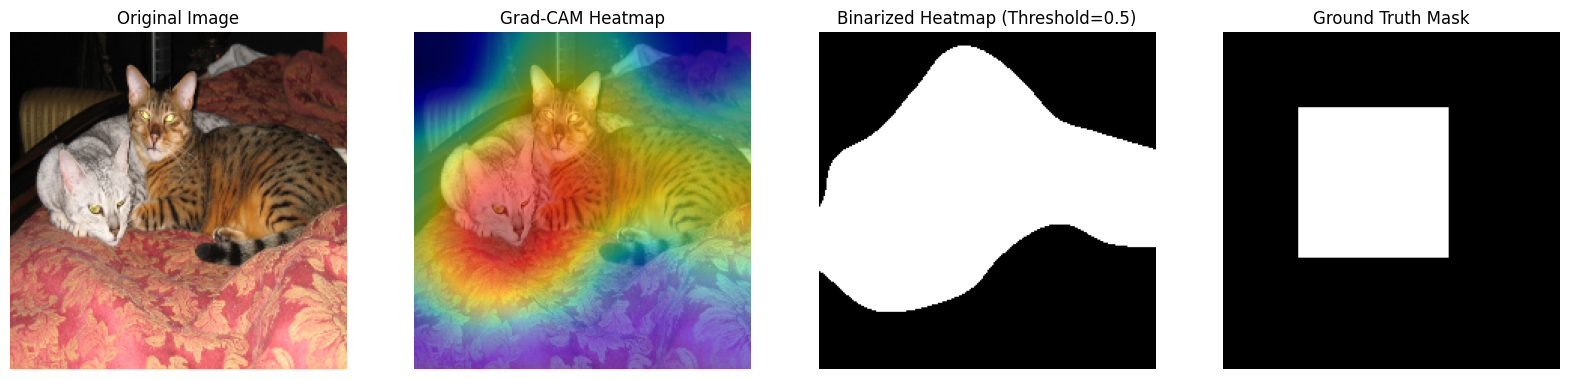

Grad-CAM Evaluation Metrics: {'IoU': np.float64(0.39469157041042024), 'Precision': np.float64(0.4006652806652807), 'Recall': np.float64(0.9636), 'Pointing Game': 1, 'Average Drop (%)': 99.99999999991476, 'Increase in Confidence (%)': -99.99999999991476}


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device)
model.eval()


url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
imagenet_classes = requests.get(url).json()
idx_to_class = {int(k): v[1] for k, v in imagenet_classes.items()}

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim & send to device
    return image_tensor

class GradCAM:
    """ Implements Grad-CAM to generate visual explanations for CNN predictions. """

    def __init__(self, model, conv_layer):
        self.model = model
        self.conv_layer = conv_layer
        self.feature_map = None
        self.gradient = None

        # Register hooks to capture feature maps & gradients
        self.conv_layer.register_forward_hook(self.forward_hook)

    def forward_hook(self, module, input, output):
        """ Capture feature maps. """
        self.feature_map = output.clone().detach()
        output.register_hook(lambda grad: setattr(self, 'gradient', grad.clone().detach()))

    def forward_pass(self, image):
        """ Runs a forward pass and gets top-3 predictions. """
        output = self.model(image).squeeze()
        probs = F.softmax(output, dim=0)
        values, indices = torch.topk(probs, k=3)

        # Find the least probable class
        least_prob_class = probs.argmin().unsqueeze(0)
        all_classes = torch.cat((indices, least_prob_class), dim=0)

        return output, values, indices, least_prob_class, all_classes, probs, self.feature_map

    def generate_cam(self, image):
        """ Generates Grad-CAM heatmaps for the top-3 classes & least probable class. """
        output, values, indices, least_prob_class, all_classes, probs, feature_map = self.forward_pass(image)
        heatmaps = []

        for label in all_classes:
            self.model.zero_grad()
            one_hot = torch.zeros_like(output)
            one_hot[label] = 1
            output.backward(gradient=one_hot, retain_graph=True)

            gradients = self.gradient.clone().detach()
            weights = F.adaptive_avg_pool2d(gradients, (1, 1))

            # Compute weighted activation map
            cam = torch.sum(weights.view(-1, 1, 1) * feature_map, dim=1, keepdim=True)
            cam = F.relu(cam.clone().detach())  # Apply ReLU
            
            # Fix pixelation issue by using bicubic interpolation
            cam = F.interpolate(cam, size=(224, 224), mode='bicubic', align_corners=True)
            cam = cam.squeeze().cpu().numpy()
            heatmaps.append(cam)

        return heatmaps, indices, values, least_prob_class, probs[least_prob_class].item()

    def show_grad_cam(self, image_tensor, orig_image):
        """ Displays Grad-CAM heatmaps for the top-3 classes & least probable class. """
        heatmaps, indices, values, least_prob_class, least_prob_value = self.generate_cam(image_tensor)

        fig, ax = plt.subplots(1, 5, figsize=(25, 5))
        ax[0].imshow(orig_image)
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        # Plot heatmaps for the top-3 predicted classes
        for i in range(3):
            ax[i + 1].imshow(orig_image)
            heatmap = np.mean(heatmaps[i], axis=0) if len(heatmaps[i].shape) > 2 else heatmaps[i]
            class_name = idx_to_class[indices[i].item()]
            ax[i + 1].imshow(heatmap, cmap='jet', alpha=0.5)
            ax[i + 1].set_title(f"{class_name} \n Score: {values[i]:.2f}")
            ax[i + 1].axis("off")

        # Plot the least probable class
        ax[4].imshow(orig_image)
        heatmap = np.mean(heatmaps[3], axis=0) if len(heatmaps[3].shape) > 2 else heatmaps[3]
        class_name = idx_to_class[least_prob_class.item()]
        ax[4].imshow(heatmap, cmap='jet', alpha=0.5)
        ax[4].set_title(f"Least Probable: {class_name} \n Score: {least_prob_value:.2f}", color="red")
        ax[4].axis("off")

        plt.show()



image_path = "TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"
image_tensor = preprocess_image(image_path)

# Load original image for visualization
orig_image = cv2.imread(image_path)
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
orig_image = cv2.resize(orig_image, (224, 224))

# Initialize Grad-CAM for ResNet-50
grad_cam = GradCAM(model, model.layer4[-1])  # Last convolutional layer


def compute_metrics(grad_cam_heatmap, ground_truth_mask, original_probs, masked_probs, threshold=0.5):
    """
    Computes evaluation metrics for Grad-CAM explanations.
    """
    # Normalize heatmap
    grad_cam_heatmap = (grad_cam_heatmap - grad_cam_heatmap.min()) / (grad_cam_heatmap.max() - grad_cam_heatmap.min())

    # Resize Grad-CAM heatmap to match the ground truth mask size (224x224)
    grad_cam_heatmap = cv2.resize(grad_cam_heatmap, (224, 224), interpolation=cv2.INTER_CUBIC)

    # Convert heatmap to binary mask using threshold
    binarized_heatmap = (grad_cam_heatmap >= threshold).astype(np.uint8)

    # Compute True Positives, False Positives, False Negatives
    intersection = np.logical_and(binarized_heatmap, ground_truth_mask).sum()
    union = np.logical_or(binarized_heatmap, ground_truth_mask).sum()
    false_positives = (binarized_heatmap == 1).sum() - intersection
    false_negatives = (ground_truth_mask == 1).sum() - intersection

    # Compute Metrics
    iou = intersection / union if union != 0 else 0
    precision = intersection / (intersection + false_positives) if (intersection + false_positives) > 0 else float('nan')
    recall = intersection / (intersection + false_negatives) if (intersection + false_negatives) > 0 else float('nan')

    # Pointing Game: Does the max activation fall inside the ground truth region?
    max_activation_point = np.unravel_index(np.argmax(grad_cam_heatmap), grad_cam_heatmap.shape)
    pointing_game_score = int(ground_truth_mask[max_activation_point] == 1)

    # Compute Average Drop and Confidence Increase
    avg_drop = ((original_probs - masked_probs) / original_probs) * 100 if original_probs > 0 else 0
    confidence_increase = ((masked_probs - original_probs) / original_probs) * 100 if original_probs > 0 else 0

    return {
        "IoU": iou,
        "Precision": precision,
        "Recall": recall,
        "Pointing Game": pointing_game_score,
        "Average Drop (%)": avg_drop,
        "Increase in Confidence (%)": confidence_increase
    }


# Define Example Ground Truth Mask
ground_truth_mask = np.zeros((224, 224), dtype=np.uint8)
ground_truth_mask[50:150, 50:150] = 1  



def binarize_heatmap(heatmap, threshold=0.5):
    """ Converts a heatmap into a binary mask using a threshold. """
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize
    return (heatmap >= threshold).astype(np.uint8)

def create_ground_truth_mask(shape=(224, 224)):
    """ Creates a binary ground truth mask (e.g., a square mask). """
    mask = np.zeros(shape, dtype=np.uint8)
    mask[50:150, 50:150] = 1 
    return mask

def visualize_gradcam(image_path, grad_cam, model):
    """ Generates and visualizes Grad-CAM heatmap, binarized heatmap, and ground truth mask. """
    # Load original image
    orig_image = cv2.imread(image_path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    orig_image = cv2.resize(orig_image, (224, 224))

    # Preprocess and generate Grad-CAM heatmap
    image_tensor = preprocess_image(image_path)
    heatmaps, _, _, _, _ = grad_cam.generate_cam(image_tensor)
    grad_cam_heatmap = heatmaps[0]  # Use heatmap of most probable class

    # Binarize heatmap
    binarized_heatmap = binarize_heatmap(grad_cam_heatmap, threshold=0.5)

    # Create ground truth mask
    ground_truth_mask = create_ground_truth_mask()

    # Create figure
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original Image
    axes[0].imshow(orig_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Grad-CAM Heatmap
    axes[1].imshow(orig_image)
    axes[1].imshow(grad_cam_heatmap, cmap="jet", alpha=0.5)
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")

    # Binarized Heatmap
    axes[2].imshow(binarized_heatmap, cmap="gray")
    axes[2].set_title("Binarized Heatmap (Threshold=0.5)")
    axes[2].axis("off")

    # Ground Truth Mask
    axes[3].imshow(ground_truth_mask, cmap="gray")
    axes[3].set_title("Ground Truth Mask")
    axes[3].axis("off")

    plt.show()



image_path = "TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"  # Change this to your image path
visualize_gradcam(image_path, grad_cam, model)


# Compute Metrics with resized heatmap
metrics = compute_metrics(grad_cam_heatmap, ground_truth_mask, values[0].item(), least_prob_value)
print("Grad-CAM Evaluation Metrics:", metrics)



## **TCAV Implementation with Integrated Gradients**

### **1. Feature Extraction for Concept Activation**
- The function `extract_ig_activations()`:
  - Runs **Integrated Gradients (IG)** on each concept dataset.
  - Extracts activations from the model to be used for TCAV training.
  - Activations are **normalized** across the dataset to standardize values.

- The IG activations for an input image $x $with respect to a target class $ y $ are computed as:

$$
IG_i(x) = (x_i - x'_i) \times \sum_{k=1}^{N} \frac{\partial f(x' + \frac{k}{N} (x - x'))}{\partial x_i} \times \frac{1}{N}
$$

where:
- $ x' $ is the **baseline image** (typically black).
- $ \alpha $ is the **scaling factor** interpolating between the baseline and input.
- $ f(x) $ is the **model's output score** for class $y $.
- $ N $ is the **number of integration steps**.



### **2. Training Concept Activation Vectors (CAVs)**
- The function `train_cav()`:
  - Uses **logistic regression** to learn **Concept Activation Vectors (CAVs)**.
  - CAVs are trained to differentiate between:
    - **Stripes vs. Random**
    - **Fur vs. Random**
    - **Face Shape vs. Random**

- Given a dataset of concept activations $ X $ and labels $ Y $, a **logistic regression model** is trained:

$$
\hat{y} = \sigma(WX + b)
$$

where:
- $ W $ is the **learned weight vector**, forming the **Concept Activation Vector (CAV)**.
- $ \sigma $ is the **sigmoid function** ensuring binary classification.
- The **CAV vector** is extracted from $W $ after training.



### **3. Computing TCAV Scores**
- `compute_tcav_score()` evaluates **how much a model relies on a concept**.
- It does so by measuring the **directional derivative** of the model’s prediction along the CAV:

$$
TCAV(C,y) = \frac{1}{|X|} \sum_{x \in X} \mathbb{1} \left[ \frac{d f_y}{d v_{C}} > 0 \right]
$$

where:
- $ v_{C} $ is the **CAV for concept $ C $**.
- $ \frac{d f_y}{d v_{C}} $ is the **directional derivative** along $v_{C} $, measuring how model confidence changes when shifting in the concept’s direction.
- $\mathbb{1} $ is an **indicator function**, counting cases where this derivative is **positive**.
- A **high TCAV score** means the model **relies on the concept** when making a prediction.





TCAV Score for 'Stripes' Concept: 0.0000
TCAV Score for 'Fur Texture' Concept: 1.0000
TCAV Score for 'Face Shape' Concept: 1.0000


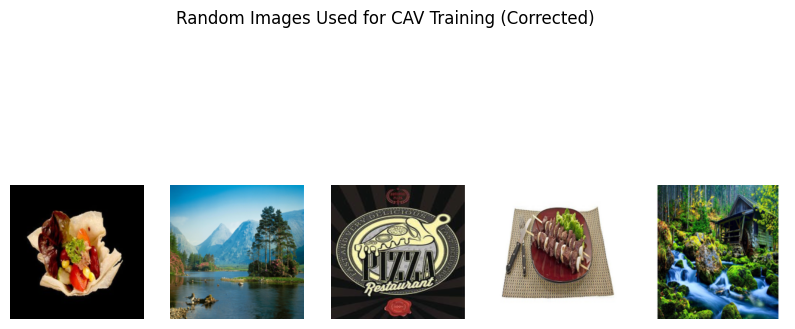

In [ ]:

# Define the image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load images and apply transformations
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ensure valid images
            try:
                image = Image.open(img_path).convert("RGB")  # Convert to RGB
                image = transform(image)
                images.append(image)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return torch.stack(images) if images else None

# Load Concept Images
stripes_images = load_images_from_folder("concepts/stripes")
fur_images = load_images_from_folder("concepts/fur_texture")
face_shape_images = load_images_from_folder("concepts/face_shape")
random_images = load_images_from_folder("concepts/random_baseline")  # Random Control Group

# Ensure valid datasets were loaded
assert stripes_images is not None, "Stripes images not loaded!"
assert fur_images is not None, "Fur images not loaded!"
assert face_shape_images is not None, "Face shape images not loaded!"
assert random_images is not None, "Random baseline images not loaded!"

# Load ResNet-50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()
target_layer = model.layer4[-1]  # Use the last convolutional layer



# Function to extract activations from a target layer
def extract_activations(model, layer, images):
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.clone().detach())

    hook = layer.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        model(images)

    hook.remove()
    return activations[0].view(images.shape[0], -1)  # Flatten activations

# Extract activations
stripes_activations = extract_activations(model, target_layer, stripes_images)
fur_activations = extract_activations(model, target_layer, fur_images)
face_shape_activations = extract_activations(model, target_layer, face_shape_images)
random_activations = extract_activations(model, target_layer, random_images)


def normalize_activations(activations):
    return (activations - activations.mean(dim=0)) / (activations.std(dim=0) + 1e-8)

stripes_activations = normalize_activations(stripes_activations)
fur_activations = normalize_activations(fur_activations)
face_shape_activations = normalize_activations(face_shape_activations)
random_activations = normalize_activations(random_activations)


def train_cav(concept_activations, random_activations):
    X = torch.cat([concept_activations, random_activations]).numpy()
    Y = np.array([1] * len(concept_activations) + [0] * len(random_activations))

    cav = LogisticRegression(C=0.1, max_iter=5000, solver="lbfgs")  # Stronger regularization
    cav.fit(X, Y)

    return cav.coef_[0]  # Concept Activation Vector (CAV)

# Train CAVs for different concepts
cav_stripes = train_cav(stripes_activations, random_activations)
cav_fur = train_cav(fur_activations, random_activations)
cav_face_shape = train_cav(face_shape_activations, random_activations)



def compute_tcav_score(image_activations, cav_vector):
    if isinstance(image_activations, torch.Tensor):
        image_activations = image_activations.detach().cpu().numpy()

    cav_vector = np.array(cav_vector)

    # Normalize correctly
    image_activations_norm = np.linalg.norm(image_activations, axis=1, keepdims=True) + 1e-8
    cav_norm = np.linalg.norm(cav_vector) + 1e-8

    image_activations /= image_activations_norm
    cav_vector /= cav_norm

    # Compute directional derivative
    directional_derivative = np.dot(image_activations, cav_vector)

    # Compute TCAV Score
    return float(np.mean(directional_derivative > 0))

# Load Image for TCAV
image_path = "TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"
image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0)
image_activations = extract_activations(model, target_layer, image_tensor)

# Compute TCAV Scores
tcav_stripes = compute_tcav_score(image_activations, cav_stripes)
tcav_fur = compute_tcav_score(image_activations, cav_fur)
tcav_face_shape = compute_tcav_score(image_activations, cav_face_shape)

print(f"TCAV Score for 'Stripes' Concept: {tcav_stripes:.4f}")
print(f"TCAV Score for 'Fur Texture' Concept: {tcav_fur:.4f}")
print(f"TCAV Score for 'Face Shape' Concept: {tcav_face_shape:.4f}")



def denormalize(tensor):
    tensor = tensor.clone().detach().cpu().permute(1, 2, 0)
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    return torch.clamp(tensor, 0, 1).numpy()

random_images_list = [denormalize(img) for img in random_images]

plt.figure(figsize=(10, 5))
random_sample = random.sample(random_images_list, min(5, len(random_images_list)))
for i, img in enumerate(random_sample):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Random Images Used for CAV Training (Corrected)")
plt.show()


### **Print Activation Shapes**
The shape of activations for each concept is printed to understand the dimensionality of the extracted activations

### **Concepts Dictionary**
The `concepts` dictionary is created to organize the activation data for each of the specific concepts that we are analyzing. Each key in the dictionary represents a concept, and the corresponding value is the set of activations associated with that concept.

```python
concepts = {
    "Stripes": stripes_activations,  # Activations for the "Stripes" concept
    "Fur Texture": fur_activations,  # Activations for the "Fur Texture" concept
    "Face Shape": face_shape_activations  # Activations for the "Face Shape" concept
}


In [ ]:


# Print activation shapes
print(f"Stripes Activation Shape: {stripes_activations.shape}")
print(f"Fur Activation Shape: {fur_activations.shape}")
print(f"Face Shape Activation Shape: {face_shape_activations.shape}")
print(f"Random Activation Shape: {random_activations.shape}")

# Compute mean activations for concepts and random baseline
mean_activation_random = random_activations.mean().item()
std_activation_random = random_activations.std().item()

concepts = {
    "Stripes": stripes_activations,
    "Fur Texture": fur_activations,
    "Face Shape": face_shape_activations
}

for concept, activations in concepts.items():
    mean_activation = activations.mean().item()
    std_activation = activations.std().item()
    print(f"Mean Activation ({concept} Concept): {mean_activation:.10f} ± {std_activation:.10f}")

# Print mean activation statistics for Random Baseline (only once)
print(f"Mean Activation (Random Baseline): {mean_activation_random:.10f} ± {std_activation_random:.10f}")

# Compute and print directional derivative statistics
image_activations_flat = image_activations.flatten()

directional_derivatives = {
    "Stripes": np.dot(image_activations_flat, cav_stripes),
    "Fur Texture": np.dot(image_activations_flat, cav_fur),
    "Face Shape": np.dot(image_activations_flat, cav_face_shape)
}

for concept, dd in directional_derivatives.items():
    print(f"Mean DD ({concept}): {dd.mean():.4f}, Std DD: {dd.std():.4f}")

# Compute TCAV Scores
tcav_scores = {
    "Stripes": compute_tcav_score(image_activations, cav_stripes),
    "Fur Texture": compute_tcav_score(image_activations, cav_fur),
    "Face Shape": compute_tcav_score(image_activations, cav_face_shape)
}

# Print final TCAV scores
for concept, score in tcav_scores.items():
    print(f"TCAV Score for '{concept}' Concept: {score:.4f}")


Stripes Activation Shape: torch.Size([86, 100352])
Fur Activation Shape: torch.Size([107, 100352])
Face Shape Activation Shape: torch.Size([143, 100352])
Random Activation Shape: torch.Size([93, 100352])
Mean Activation (Stripes Concept): 0.0000000007 ± 0.9941691160
Mean Activation (Fur Texture Concept): 0.0000000004 ± 0.9953162074
Mean Activation (Face Shape Concept): 0.0000000001 ± 0.9964973927
Mean Activation (Random Baseline): 0.0000000004 ± 0.9946091771
Mean DD (Stripes): -0.0000, Std DD: 0.0000
Mean DD (Fur Texture): 0.0000, Std DD: 0.0000
Mean DD (Face Shape): 0.0000, Std DD: 0.0000
TCAV Score for 'Stripes' Concept: 0.0000
TCAV Score for 'Fur Texture' Concept: 1.0000
TCAV Score for 'Face Shape' Concept: 1.0000


/var/folders/xv/76zyg58x4_96rxvg794ms7rr0000gn/T/ipykernel_88287/1607202230.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  "Stripes": np.dot(image_activations_flat, cav_stripes),
/var/folders/xv/76zyg58x4_96rxvg794ms7rr0000gn/T/ipykernel_88287/1607202230.py:33: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  "Fur Texture": np.dot(image_activations_flat, cav_fur),
/var/folders/xv/76zyg58x4_96rxvg794ms7rr0000gn/T/ipykernel_88287/1607202230.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  "Face Shape": np.dot(image_activations_flat, cav_face_shape)
